In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/"My Drive"/"Colab Notebooks"/shared_task/han

/content/drive/My Drive/Colab Notebooks/shared_task/han


In [3]:
from IPython.display import HTML, display
import pandas as pd
import numpy as np
import keras
from keras.preprocessing.text import Tokenizer,  text_to_word_sequence
from keras.layers import Layer
from keras import initializers as initializers, regularizers, constraints
from keras.callbacks import Callback, ModelCheckpoint
from keras.utils import to_categorical
from keras.layers import Embedding, Input, Dense, LSTM, GRU, Bidirectional, TimeDistributed, Dropout, concatenate, SpatialDropout1D, Flatten, Activation
from keras import backend as K
from keras import optimizers
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Model
from keras.callbacks import *
from clr_callback import *
import nltk
import re
import matplotlib.pyplot as plt
import sys
import os
from sklearn.metrics import roc_auc_score
from nltk import tokenize
from sklearn.utils import shuffle
import seaborn as sns
import nltk
nltk.download("punkt")
from sklearn.model_selection import train_test_split
sys.path.append('..')
from preprocessing.preprocessing_data import *
from sklearn.metrics import classification_report, confusion_matrix
from utilities.utilities import *

Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


### Attention Layer

In [0]:
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatibl|e with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

### Config

In [0]:
max_features=200000
max_senten_len=200
max_senten_num=3
embed_size=200
#VALIDATION_SPLIT = 0.2

### Data

In [0]:
X_train_mix, y_train = read_normalised("../data/normalised_hindi_train.json")
X_test_mix, y_test = read_normalised("../data/normalised_hindi_dev.json")

In [0]:
with open("../data/english_hinglish_train.txt", "r") as f:
    X_train_eng = []
    for line in f:
        line = line.strip()
        X_train_eng.append(line)

with open("../data/english_hinglish_dev.txt", "r") as f:
    X_test_eng = []
    for line in f:
        line = line.strip()
        X_test_eng.append(line)

In [0]:
with open("../data/hindi_hinglish_train.txt", "r") as f:
    X_train_span = []
    for line in f:
        line = line.strip()
        X_train_span.append(line)

with open("../data/hindi_hinglish_dev.txt", "r") as f:
    X_test_span = []
    for line in f:
        line = line.strip()
        X_test_span.append(line)

In [0]:
import string
def remove_dots(sentence):
    return sentence.translate(str.maketrans('', '', string.punctuation))

In [0]:
df_all = pd.DataFrame(data={'codemixed': X_train_mix + X_test_mix, 
                            'english': X_train_eng + X_test_eng, 
                            'spanish': X_train_span + X_test_span, 
                            'categories': y_train + y_test,
                            'is_which_set': ["train"]*len(X_train_mix) + ["test"]*len(X_test_mix)})

# df_all = pd.DataFrame(data={'codemixed': X_train_mix + X_extra_spanglish + X_test_mix, 
#                             'english': X_train_eng + X_extra_english + X_test_eng, 
#                             'spanish': X_train_span + X_extra_spanish + X_test_span, 
#                             'categories': y_train + Y_extra + y_test,
#                             'is_which_set': ["train"]*len(X_train_mix+X_extra_spanglish) + ["test"]*len(X_test_mix)})

In [0]:
df_all["codemixed"] = df_all["codemixed"].apply(remove_dots)
df_all["english"] = df_all["english"].apply(remove_dots)
df_all["spanish"] = df_all["spanish"].apply(remove_dots)

In [0]:
import re
def clean_str(string):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()

In [0]:
def preprocess(df, show_plots=False):
    shuf_df = shuffle(df).reset_index(drop=True)
    shuf_df.head()

    shuf_df['text'] = shuf_df['codemixed'] + '. ' + shuf_df['english'] + '. ' + shuf_df['spanish']

    df = shuf_df[["text", "categories", "is_which_set"]]

    categories = df['categories']
    text = df['text']
    is_set = df['is_which_set']

    set_ids = pd.get_dummies(is_set)
    train_indices = set_ids.index[set_ids['train'] == 1].tolist()
    test_indices = set_ids.index[set_ids['train'] == 0].tolist()
    the_text = text.tolist()
    sentences_for_analysis = [the_text[i] for i in train_indices]

    cates = df.groupby('categories')
    print("Total sentiment categories:", cates.ngroups)
    print(cates.size())

    paras, labels, texts = [], [], []

    sent_lens, sent_nums = [], []
    for idx in range(df.text.shape[0]):
        text = clean_str(df.text[idx])
        texts.append(text)
        sentences = tokenize.sent_tokenize(text)
        sent_nums.append(len(sentences))
        for sent in sentences:
            sent_lens.append(len(text_to_word_sequence(sent)))
        paras.append(sentences)

    if show_plots:
        sns.distplot(sent_lens, bins=200)
        plt.show()
        sns.distplot(sent_nums)
        plt.show()

    tokenizer = Tokenizer(num_words=max_features, oov_token=True)
    tokenizer.fit_on_texts(texts)

    data = np.zeros((len(texts), max_senten_num, max_senten_len), dtype='int32')
    for i, sentences in enumerate(paras):
        for j, sent in enumerate(sentences):
            if j< max_senten_num:
                wordTokens = text_to_word_sequence(sent)
                k=0
                for _, word in enumerate(wordTokens):
                    try:
                        if k<max_senten_len and tokenizer.word_index[word]<max_features:
                            data[i,j,k] = tokenizer.word_index[word]
                            k=k+1
                    except:
                        print(word)
                        pass

    word_index = tokenizer.word_index
    print('Total %s unique tokens.' % len(word_index))

    labels = pd.get_dummies(categories)
    is_set = pd.get_dummies(is_set)

    print('Shape of data tensor:', data.shape)
    print('Shape of labels tensor:', labels.shape)

    x_train, y_train, x_val, y_val = data, labels, data, labels

    train_indices = is_set.index[is_set['train'] == 1].tolist()
    test_indices = is_set.index[is_set['train'] == 0].tolist()

    y_train = y_train.iloc[train_indices]
    y_val = y_val.iloc[test_indices]

    x_train = np.delete(x_train, test_indices, axis=0)
    x_val = np.delete(x_val, train_indices, axis=0)

    indices = np.arange(x_train.shape[0])
    np.random.shuffle(indices)

    x_train = x_train[indices]
    y_train = y_train.iloc[indices]

    indices = np.arange(x_val.shape[0])
    np.random.shuffle(indices)

    x_val = x_val[indices]
    y_val = y_val.iloc[indices]

    return x_train, y_train, x_val, y_val, is_set, word_index, sentences_for_analysis

In [14]:
x_train, y_train, x_val, y_val, is_set, word_index, sentences_for_analysis = preprocess(df_all)

Total sentiment categories: 3
categories
negative    4992
neutral     6392
positive    5616
dtype: int64
Total 77436 unique tokens.
Shape of data tensor: (17000, 3, 200)
Shape of labels tensor: (17000, 3)


In [15]:
print('Number of positive, neutral and negative reviews in traing and validation set')
print(y_train.columns.tolist())
print(y_train.sum(axis=0).tolist())
print(y_val.sum(axis=0).tolist())

Number of positive, neutral and negative reviews in traing and validation set
['negative', 'neutral', 'positive']
[4102, 5264, 4634]
[890, 1128, 982]


### Model

In [0]:
REG_PARAM = 1e-13
l2_reg = regularizers.l2(REG_PARAM)

In [17]:
#EMBEDDING_DIR = "crosslingual_EN-ES_english_twitter_100d_weighted.txt"
EMBEDDING_DIR = "glove.twitter.27B.200d.txt"
embeddings_index = {}
f = open(EMBEDDING_DIR)
for line in f:
    try:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except:
        print(word)
        pass
f.close()
print('Total %s word vectors.' % len(embeddings_index))

Total 1193514 word vectors.


In [18]:
embedding_matrix = np.zeros((len(word_index) + 1, embed_size))
absent_words = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        absent_words += 1
print('Total absent words are', absent_words, 'which is', "%0.2f" % (absent_words * embed_size / len(word_index)), '% of total words')

Total absent words are 54872 which is 141.72 % of total words


In [19]:
embedding_layer = Embedding(len(word_index) + 1,embed_size,weights=[embedding_matrix], input_length=max_senten_len, trainable=False)

In [20]:
word_input = Input(shape=(max_senten_len,), dtype='float32')
word_sequences = embedding_layer(word_input)

word_lstm = Bidirectional(LSTM(150, return_sequences=True, kernel_regularizer=l2_reg))(word_sequences)
word_dense = TimeDistributed(Dense(200, kernel_regularizer=l2_reg))(word_lstm)
word_att = AttentionWithContext()(word_dense)
wordEncoder = Model(word_input, word_att)

sent_input = Input(shape=(max_senten_num, max_senten_len), dtype='float32')
sent_encoder = TimeDistributed(wordEncoder)(sent_input)
sent_lstm = Bidirectional(LSTM(150, return_sequences=True, kernel_regularizer=l2_reg))(sent_encoder)
sent_dense = TimeDistributed(Dense(200, kernel_regularizer=l2_reg))(sent_lstm)
sent_att = Dropout(0.5)(AttentionWithContext()(sent_dense))
preds = Dense(3, activation='softmax')(sent_att)
model = Model(sent_input, preds)
# 0.01 lr works best, 0.0001 lr is very stable
# 0.1 lr works for CyclicLR, 0.05490 after 16 epochs
clr_triangular = CyclicLR(mode="triangular")
model.compile(loss='categorical_crossentropy',optimizer=Adam(0.1, amsgrad=True),metrics=['acc'])










Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [0]:
checkpoint = ModelCheckpoint('final_han_hinglish_checkpoint.h5', verbose=0, monitor='val_loss', save_best_only=True, mode='auto') 

In [22]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=14, batch_size=1024, callbacks=[checkpoint, clr_triangular])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 14000 samples, validate on 3000 samples
Epoch 1/14
14000/14000 [==============================] - 26s 2ms/step - loss: 1.0123 - acc: 0.4701 - val_loss: 0.9172 - val_acc: 0.5450
Epoch 2/14
14000/14000 [==============================] - 21s 2ms/step - loss: 0.9091 - acc: 0.5498 - val_loss: 0.8830 - val_acc: 0.5830
Epoch 3/14
14000/14000 [==============================] - 22s 2ms/step - loss: 0.8728 - acc: 0.5847 - val_loss: 0.8731 - val_acc: 0.5883
Epoch 4/14
14000/14000 [==============================] - 22s 2ms/step - loss: 0.8402 - acc: 0.6104 - val_loss: 0.8765 - val_acc: 0.5907
Epoch 5/14
14000/14000 [==============================] - 22s 2ms/step - loss: 0.8311 - acc: 0.6132 - val_loss: 0.8466 - val_acc: 0.5967
Epoch 6/14
14000/14000 [==============================] - 23s 2ms/step - loss: 0.8101 - acc: 0.6274 - val_loss: 0.8500 - val_acc: 0.6030
Epoch 7/14
14000/14000 [=========

## Plotting time

In [0]:
#print(history.history.keys())

In [0]:
# #% matplotlib inline
# from matplotlib import style
# style.use('seaborn-ticks')

# # summarize history for accuracy
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [0]:
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [0]:
def create_custom_objects():
    instance_holder = {"instance": None}

    class ClassWrapper(AttentionWithContext):
        def __init__(self, *args, **kwargs):
            instance_holder["instance"] = self
            super(ClassWrapper, self).__init__(*args, **kwargs)

    def loss(*args):
        method = getattr(instance_holder["instance"], "loss_function")
        return method(*args)

    def accuracy(*args):
        method = getattr(instance_holder["instance"], "accuracy")
        return method(*args)
    return {"ClassWrapper": ClassWrapper ,"AttentionWithContext": ClassWrapper, "loss": loss,
            "accuracy":accuracy}

# Evaluation

In [0]:
# attention_analysis_model_final
model.save('final_han_hinglish.h5')

In [0]:
# loaded_model = keras.models.load_model('han_2020.h5', custom_objects={"AttentionWithContext": AttentionWithContext})
loaded_model = keras.models.load_model('final_han_hinglish.h5', custom_objects=create_custom_objects())
# loaded_model = model

In [29]:
loaded_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3, 200)            0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 3, 200)            16009200  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 3, 300)            421200    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 3, 200)            60200     
_________________________________________________________________
attention_with_context_2 (Cl (None, 200)               40400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 603 

3000/3000 [==============================] - 13s 4ms/step
              precision    recall  f1-score   support

           0       0.62      0.53      0.57       890
           1       0.50      0.62      0.55      1128
           2       0.68      0.57      0.62       982

    accuracy                           0.58      3000
   macro avg       0.60      0.57      0.58      3000
weighted avg       0.59      0.58      0.58      3000



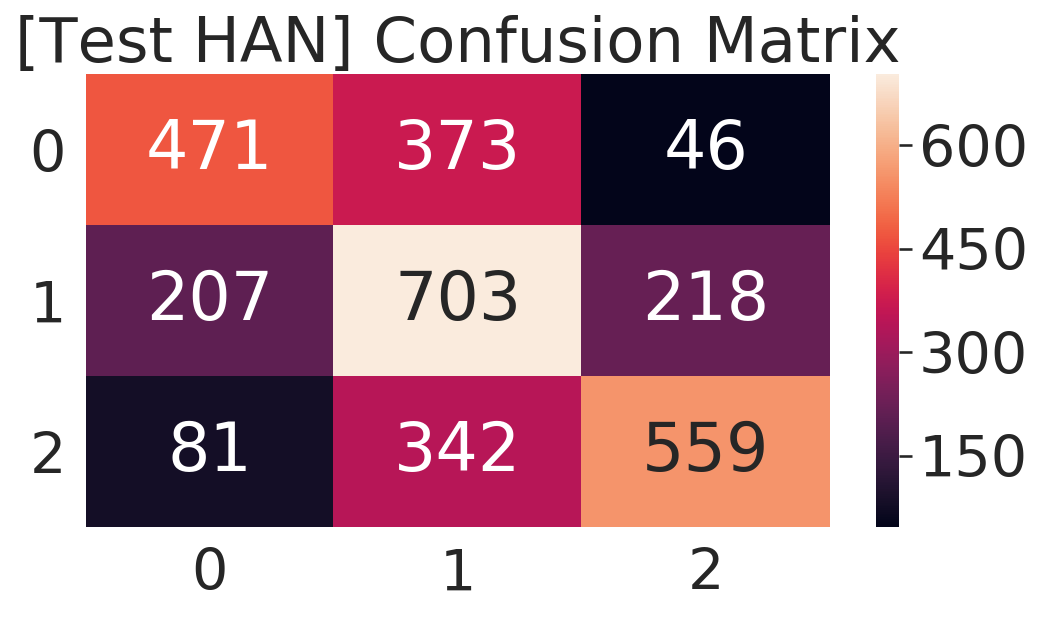

In [30]:
y_pred = loaded_model.predict(x_val, batch_size=64, verbose=1)
y_pred_r = np.argmax(y_pred, axis=1)

y_test = [i.index(1) for i in y_val.values.tolist()]

print(classification_report(y_test, y_pred_r))

confusion_m = np.zeros(shape=(len(set(y_test)),len(set(y_test))))
confusion_m = np.add(confusion_m, confusion_matrix(y_test, y_pred_r, labels = [0,1,2]))

create_confusion_matrix(confusion_m, [0,1,2], y_lim_value=3.0, title="[Test HAN]", show_plots=True, save_plots=False, method="TESTING", fig_size=(8,4))

In [0]:
with open("han.txt", "w") as f:
    for line in y_pred_r:
        f.write(str(line) + "\n")

# Attention Analysis